<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# CAPSTONE : Ubisoft's Assassin's Creed IV – Predicting Topics From Reviews

# Part 5 – Topic Labelling: Open AI

Moving on to the main aim of our problem statement, topic labelling.

Our aim is to train our model to recognise and label topics mentioned in each review. As there are some reviews that are quite comprehensive in a sense that they are very descriptive in going into detail for the pros and cons of certain elements of the game or platform, we need to identify topics for each review.

In order to do this, we will use a few unsupervised models to extract these topics, and cross examine these labels with our own judgement to determine if the the reviews were accurately labelled.

In [93]:
# nltk.download('punkt')
# nltk.download('wordnet')
# !pip install gensim
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install rake-nltk

In [141]:
# Importing all libraries used: 

import pandas as pd
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from gensim import models, corpora

from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

import re

import sys
import numpy as np
from pprint import pprint

import spacy
from collections import Counter
from string import punctuation

from rake_nltk import Rake
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

from tqdm import tqdm
import openai
import json
from json import JSONDecodeError

from sklearn.metrics import classification_report

from time import sleep
import random

## Importing Data

For this unsupervised modelling, we will be using the cleaned dataset, but without the stopwords removed.

In [96]:
ass_creed = pd.read_csv('../data/output/ass_creed_no_punc.csv')

In [97]:
ass_creed

,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,review,timestamp_created,recommended,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,267,21,2856,0,2856,2018-02-18 19:42:24,the only game where i avoid fast travel,2021-01-27 20:27:22,True,3748,185,0.986815,11,True,False,False
1,0,52,1838,0,1838,2020-07-01 11:12:26,this is the best assassins creed game and prob...,2020-09-19 13:12:59,True,2558,37,0.979318,11,True,False,False
2,0,2,117391,77,90196,2023-08-26 03:33:05,best game ever iv 'e been playing from day one...,2020-05-23 19:09:36,True,2190,227,0.979193,0,True,False,False
3,77,4,4719,0,4036,2021-04-03 17:48:13,shanties before panties,2021-03-10 19:36:02,True,2174,897,0.974363,11,True,False,False
4,0,10,1592,0,1177,2022-02-11 01:37:29,best part of the game are the sea shanties low...,2020-06-27 00:22:26,True,1041,240,0.958593,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21807,0,6,5486,0,2550,2016-03-13 15:32:17,buy this on the ps4 i had routine full system ...,2014-12-27 00:48:44,False,0,0,0.000000,0,False,False,False
21808,0,13,5562,0,5562,2014-12-26 23:32:10,i dont typicaly do reviews however this game p...,2014-12-26 23:22:59,True,0,0,0.000000,0,True,False,False
21809,0,72,3783,0,289,2015-05-09 13:37:50,buy this one instead of unity,2014-12-26 22:20:35,True,0,0,0.000000,0,True,False,False
21810,0,69,2374,0,2374,2014-08-04 01:35:35,great game that takes the open world concept a...,2014-12-26 21:45:06,True,0,0,0.000000,0,True,False,False


In [99]:
ass_creed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21812 entries, 0 to 21811
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   num_games_owned              21812 non-null  int64  
 1   num_reviews                  21812 non-null  int64  
 2   playtime_forever             21812 non-null  int64  
 3   playtime_last_two_weeks      21812 non-null  int64  
 4   playtime_at_review           21812 non-null  int64  
 5   last_played                  21812 non-null  object 
 6   review                       21729 non-null  object 
 7   timestamp_created            21812 non-null  object 
 8   recommended                  21812 non-null  bool   
 9   votes_up                     21812 non-null  int64  
 10  votes_funny                  21812 non-null  int64  
 11  weighted_vote_score          21812 non-null  float64
 12  comment_count                21812 non-null  int64  
 13  steam_purchase  

In [100]:
# Our data still had some null values, let's drop these
ass_creed.dropna(inplace= True)

In [101]:
ass_creed.reset_index(drop= True, inplace = True)

## Latent Dirichlet Allocation

[Latent Dirichlet Allocation (LDA)](https://www.analyticsvidhya.com/blog/2021/06/part-18-step-by-step-guide-to-master-nlp-topic-modelling-using-lda-probabilistic-approach/) is an "algorithm exactly finding the weight of connections between documents and topics and between topics and words". This method is supposed to output the top words in each topic. From there, we are supposed to manually determine which topic these words and phrases belong to.

LDA needs to be used on cleaned data, including removing the stopwords, so that there is less noise in the data.

In [108]:
stop_words=set(nltk.corpus.stopwords.words('english'))

For testing purposes, we will be using the first 50 rows to see if we are satisfied with the groupings of topics.

In [110]:
vect =TfidfVectorizer(stop_words='english',max_features=1000, ngram_range=(1,1))
vect_text=vect.fit_transform(ass_creed['review'][:50])

In [114]:
lda_model=LatentDirichletAllocation(n_components=10,
learning_method='online',random_state=42,max_iter=1) 
lda_top=lda_model.fit_transform(vect_text)

In [115]:
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Topic  0 :  3.457153246010586 %
Topic  1 :  3.457267070757303 %
Topic  2 :  3.4570852299250423 %
Topic  3 :  3.457144428043885 %
Topic  4 :  68.88597066755366 %
Topic  5 :  3.457097999230163 %
Topic  6 :  3.4571019786505253 %
Topic  7 :  3.4570099474208598 %
Topic  8 :  3.4570388124933418 %
Topic  9 :  3.4571306199146252 %


In [116]:
vocab = vect.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
            print("")
     print("\n")

Topic 0: 
shanties 
cool 
game 
creed 
poppin 
worth 
title 
series 
best 
waterspouts 


Topic 1: 
scourge 
pet 
oversaturate 
10 
url 
plantations 
game 
younger 
perception 
especially 


Topic 2: 
tr 
chests 
thieves 
stealthing 
td 
weaker 
slooooow 
th 
camera 
amazing 


Topic 3: 
honest 
universe 
hate 
later 
exploring 
overloaded 
revealing 
trend 
visit 
best 


Topic 4: 
rig 
palatable 
hunting 
10 
make 
shit 
reinforced 
simplicity 
subjective 
avoid 


Topic 5: 
target 
10 
walls 
especially 
thing 
trivial 
actual 
money 
originality 
major 


Topic 6: 
panties 
spent 
way 
price 
publicly 
problems 
stealth 
simple 
twice 
great 


Topic 7: 
love 
cooler 
months 
opens 
tedious 
island 
replayable 
pages 
edward 
sandboxy 


Topic 8: 
tropes 
wars 
ms 
best 
public 
required 
winning 
spend 
stacks 
easily 


Topic 9: 
unplayable 
bugs 
unique 
content 
lost 
symptoms 
selling 
absolutely 
piece 
reinforced 




Judging the labels in each topic, we currently see that there is no correlation in each topic. Let's try to reduce the number of topics to see if this helps.

In [117]:
lda_model=LatentDirichletAllocation(n_components=5,
learning_method='online',random_state=42,max_iter=1) 
lda_top=lda_model.fit_transform(vect_text)

In [118]:
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Topic  0 :  7.0963432710603 %
Topic  1 :  7.115786940963331 %
Topic  2 :  7.083839472612015 %
Topic  3 :  7.091942153012411 %
Topic  4 :  71.61208816235194 %


In [119]:
vocab = vect.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
            print("")
     print("\n")

Topic 0: 
shanties 
cool 
game 
worth 
title 
poppin 
breaks 
multiplayer 
panties 
series 


Topic 1: 
scourge 
game 
best 
love 
oversaturate 
ac 
ve 
plantations 
perception 
great 


Topic 2: 
chests 
game 
tr 
edit 
gold 
thieves 
stealthing 
weaker 
td 
sh 


Topic 3: 
honest 
universe 
quite 
exploring 
hate 
best 
overloaded 
visit 
revealing 
software 


Topic 4: 
10 
game 
rig 
hunting 
make 
fun 
ship 
characters 
previous 
palatable 




Unfortunately, reducing the number of topics still did not help the model extract relevant words for each topic.

Tuning the parameters again to try and include 2-gram words as well, let's see if this does a better job.

In [120]:
vect =TfidfVectorizer(stop_words='english',max_features=1000, ngram_range=(1,2))
vect_text=vect.fit_transform(ass_creed['review'][:50])

In [121]:
lda_model=LatentDirichletAllocation(n_components=5,
learning_method='online',random_state=42,max_iter=1) 
lda_top=lda_model.fit_transform(vect_text)

In [122]:
for i,topic in enumerate(lda_top[0]):
  print("Topic ",i,": ",topic*100,"%")

Topic  0 :  6.536443768065749 %
Topic  1 :  6.5394110313870435 %
Topic  2 :  73.88108167946345 %
Topic  3 :  6.531675889087054 %
Topic  4 :  6.5113876319966915 %


In [123]:
vocab = vect.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
            print(t[0],end=" ")
            print("")
     print("\n")

Topic 0: 
character 
story 
hours hours 
td 10 
tr 
war 
early morning 
money requirements 
ride 
target 


Topic 1: 
pirate portion 
jackdaw 
like 
long shot 
fun game 
younger 
walls 
usual 
pirates like 
better 


Topic 2: 
series 
game 
start 
best assassin 
run microwave 
best assassins 
price 
warning played 
bad really 
thought 


Topic 3: 
panties 
shanties 
tr th 
love 
diving 
voice 
feel 
temple runners 
issue 
needed 


Topic 4: 
10 
best 
plus 
game 
parts assassin 
kill 
sea combat 
sea 
following 
assassin 




Breaking this down per topic,

Topic 0: Only 'character', 'story' could be grouped together <br>
Topic 1: Only 'pirate portion' and 'pirates like' could be grouped together <br>
Topic 2: 'series', 'game', 'best assassins', 'best assassin' can be grouped together. <br> 
This is currently the one with the most relevance, however, still not the best as the rest of the words would not be part of the same category. <br>
Topic 3: None of these words are part of the same topic <br>
Topic 4: Only 'sea', 'sea combat' or 'kill', 'sea combat' could be grouped together. <br> 'parts assassin' and 'assassin' should technically be part of the Topic 2 group with the other 'assassin' words.

### Tokenize, RAKE, LDA

Let's try adding tokenization and RAKE keyword extraction before our LDA process and test is the predictions get better.

In [133]:
# Using the first 50 rows as test data
data = pd.DataFrame(ass_creed['review'][0:50])

In [134]:
# Preprocess the text data (tokenization, lowercase, remove stopwords)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    words = [word for word in words if word not in stop_words]
    return words

data['tokenized_text'] = data['review'].apply(preprocess_text)

In [135]:
data

,review,tokenized_text
0,the only game where i avoid fast travel,"[game, avoid, fast, travel]"
1,this is the best assassins creed game and prob...,"[best, assassins, creed, game, probably, best,..."
2,best game ever iv 'e been playing from day one...,"[best, game, ever, iv, e, playing, day, one, l..."
3,shanties before panties,"[shanties, panties]"
4,best part of the game are the sea shanties low...,"[best, part, game, sea, shanties, lowkey, 1700..."
5,pros -beautiful graphics -huge artistic work -...,"[pros, graphics, artistic, work, world, battle..."
6,the best assassin 's creed game since assassin...,"[best, assassin, creed, game, since, assassin,..."
7,on 12th december its free on uplay edit i made...,"[12th, december, free, uplay, edit, made, revi..."
8,before i start i just want to address one thin...,"[start, want, address, one, thing, best, ac, g..."
9,i love this game what can be better than liste...,"[love, game, better, listening, sea, shanties,..."


In [138]:
# Perform keyword extraction using RAKE
def extract_keywords(text):
    r = Rake()
    r.extract_keywords_from_text(text)
    return r.get_ranked_phrases()

data['keywords'] = data['review'].apply(extract_keywords)

In [139]:
data

,review,tokenized_text,keywords
0,the only game where i avoid fast travel,"[game, avoid, fast, travel]","[avoid fast travel, game]"
1,this is the best assassins creed game and prob...,"[best, assassins, creed, game, probably, best,...","[best pirate game ever, best assassins creed g..."
2,best game ever iv 'e been playing from day one...,"[best, game, ever, iv, e, playing, day, one, l...","[75 years young arrrrr matey, best game ever i..."
3,shanties before panties,"[shanties, panties]","[shanties, panties]"
4,best part of the game are the sea shanties low...,"[best, part, game, sea, shanties, lowkey, 1700...","[sea shanties lowkey 1700, best part, poppin, ..."
5,pros -beautiful graphics -huge artistic work -...,"[pros, graphics, artistic, work, world, battle...",[seriously ... uplay advice disable cloud save...
6,the best assassin 's creed game since assassin...,"[best, assassin, creed, game, since, assassin,...","[improved sword fighting feels alot better, mo..."
7,on 12th december its free on uplay edit i made...,"[12th, december, free, uplay, edit, made, revi...","[review 4 years ago pls stop commenting, profi..."
8,before i start i just want to address one thin...,"[start, want, address, one, thing, best, ac, g...",[islands fisherman villages caves mayan ruins ...
9,i love this game what can be better than liste...,"[love, game, better, listening, sea, shanties,...","[sea shanties, pirate, love, listening, game, ..."


In [140]:
# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(data['tokenized_text'])
corpus = [dictionary.doc2bow(text) for text in data['tokenized_text']]

# Apply LDA
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

# Assign topics to documents
data['lda_topics'] = data['tokenized_text'].apply(lambda x: lda_model[dictionary.doc2bow(x)])

# Print the assigned topics for each document
for index, row in data.iterrows():
    print(f"Document {index + 1} - LDA Topics: {row['lda_topics']}")

Document 1 - LDA Topics: [(0, 0.22033806), (1, 0.020003153), (2, 0.020002749), (3, 0.020004865), (4, 0.020002251), (5, 0.02000294), (6, 0.020002916), (7, 0.020002564), (8, 0.020003207), (9, 0.6196373)]
Document 2 - LDA Topics: [(0, 0.010000278), (1, 0.0100007225), (2, 0.010001923), (3, 0.010001593), (4, 0.010001522), (5, 0.01000164), (6, 0.010003461), (7, 0.010000836), (8, 0.010001953), (9, 0.909986)]
Document 3 - LDA Topics: [(9, 0.93999064)]
Document 4 - LDA Topics: [(0, 0.033335913), (1, 0.033335913), (2, 0.03333858), (3, 0.6999703), (4, 0.033335913), (5, 0.033337582), (6, 0.033335913), (7, 0.033335913), (8, 0.033335913), (9, 0.033338066)]
Document 5 - LDA Topics: [(0, 0.010000795), (1, 0.0100009795), (2, 0.010001439), (3, 0.909985), (4, 0.010001249), (5, 0.010001666), (6, 0.010001161), (7, 0.010000982), (8, 0.01000294), (9, 0.010003764)]
Document 6 - LDA Topics: [(0, 0.97631395)]
Document 7 - LDA Topics: [(8, 0.993661)]
Document 8 - LDA Topics: [(5, 0.96666306)]
Document 9 - LDA To

In [166]:
# Get the top N terms for each topic
num_terms = 10  # Adjust as needed
topic_keywords = {}

for topic_id in range(lda_model.num_topics):
    # Get the top terms for the current topic
    topic_terms = lda_model.get_topic_terms(topic_id, topn=num_terms)
    
    # Convert term IDs to actual terms using the dictionary
    terms = [dictionary[id] for id, _ in topic_terms]
    
    # Store the terms for this topic
    topic_keywords[topic_id] = terms

# Print the keywords for each topic
for topic_id, terms in topic_keywords.items():
    print(f"Topic {topic_id + 1} Keywords: {', '.join(terms)}")

Topic 1 Keywords: game, story, bad, ship, good, get, like, full, amount, creed
Topic 2 Keywords: game, ship, sea, missions, good, ac, also, pirate, though, day
Topic 3 Keywords: game, one, help, mods, enhance, creed, good, assassins, pirates, plus
Topic 4 Keywords: game, hours, story, could, ship, long, assassin, good, best, games
Topic 5 Keywords: game, creed, flag, best, games, one, assassin, black, pirate, story
Topic 6 Keywords: game, assassin, best, creed, sea, ubisoft, got, shanties, right, part
Topic 7 Keywords: game, good, combat, world, fun, meh, never, better, bad, like
Topic 8 Keywords: game, sailing, flag, black, would, assassin, creed, thing, title, running
Topic 9 Keywords: series, game, great, shot, largely, since, missions, still, pirate, would
Topic 10 Keywords: way, rises, hay, early, morning, put, drunken, sailor, game, combat


Looking through our topic keywords again, the LDA Model does not seem to pick out topics very well.

- 'Game' is in almost every single topic
- 'Story', which could be a category in itself, is in more than one topic
- 'Assassin(s)' comes up in multiple topics as well
- 'Ship' also appears in many of the topics.

From human judgement, upon comparing the model's results, we cannot agree with all the model's topic outputs and how they've been categorised.

As such, we will prompt the GPT3.5 Turbo model to extract relevant topics and their keywords, to then again, compare with our judgement to evaluate whether the model performed well enough for us to run through our dataset.

## Open AI

The Open AI API Key can be obtained [here](https://platform.openai.com/).

In [14]:
openai.api_key = "sk-"

In [15]:
def topic_extract(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

In order to properly determine a good range of topics, ideally, we would:

1) Run the model through our entire dataset to get it to output a maximum of 2 topics per review.
2) Narrow these topics down into their relevant categories
3) Run the model through our entire dataset again to label each review within the narrowed down categories

However, in the interset of time and money, we will instead take a random sample of 1,000 reviews and run this through our model for the first step.

### Unsupervised Model: No Topic Limitation

In [ ]:
ass_creed_no_punc = pd.read_csv('../data/output/ass_creed_no_punc.csv')

In [186]:
sample = ass_creed_no_punc.sample(n = 1_000, random_state= 123)

We are prompting our model to:
1) Extract a maximum of 2 topics from the reviews.
    - Each topic should strictly be between 1 to 2 words in length.
    - If no topic is able to be extracted, return "no topic"
    - Avoid using "Assassin's Creed" and "game" as a topic.
    - Avoid using sentiment such as "best", "good" or "bad" or equivalent as a topic.
        
2) Identify the top 5 keywords in the reviews that lead to the conclusion of these topics.
    - If no topic is able to be extracted, return "".

In [192]:
# Defining the extract topic function to retry if it runs into an error
def extract_topic_with_retry(prompt, max_retries=5, retry_delay=5):
    for attempt in range(max_retries):
        try:
            response_text = topic_extract(prompt)  # Call helper function to perform tasks in prompt
            response = json.loads(response_text)  # Try to parse JSON String to Python dictionary
            return response  # If successful, return the response
            
        except JSONDecodeError as jde:
            if attempt < max_retries - 1:
                # If a JSONDecodeError occurred and we have more retries left, wait and retry
                print(f"JSONDecodeError encountered. Retrying in {retry_delay} seconds...")
                sleep(retry_delay)
                continue
            else:
                # If the maximum number of retries is reached, raise the JSONDecodeError
                raise
                
        except Exception as e:
            if attempt < max_retries - 1:
                # If any other error occurred and we have more retries left, wait and retry
                print(f"Error encountered. Retrying in {retry_delay} seconds...")
                sleep(retry_delay)
                continue
            else:
                # If the maximum number of retries is reached or another exception occurred, raise it
                raise

# response_topic = []   # Use this line to start out with
response_topic = response_topic[:360]    # Use this line if interrupted halfway to continue where it left off

# Looping through through all text reviews and run text analysis for first 1000 of the dataframe in batches of 50
leftover_review = sample['review'][len(response_topic):500].to_list()

batch_size = 40  # Number of reviews to process in each batch
total_reviews = len(leftover_review)

# Calculate the total number of batches, accounting for potential remaining reviews
total_batches = (total_reviews + batch_size - 1) // batch_size

for batch_number in tqdm(range(total_batches), total=total_batches):
    start_index = batch_number * batch_size
    end_index = min(start_index + batch_size, total_reviews)  # Ensure we don't go beyond the end of the list
    batch_reviews = leftover_review[start_index:end_index]  # Get a batch of reviews

    batch_responses = []  # List to store responses for this batch

    for review in tqdm(batch_reviews, desc=f"Batch {batch_number+1}/{total_batches}"): # Add a description to the tqdm progress bar
        # try translation and sentiment inference based on prompt until an error is encountered
        prompt = f"""
    
        Perform the following action on the given text delimited by triple backticks:
        
        1) Extract a maximum of 2 topics from the reviews.
        - Each topic should strictly be between 1 to 2 words in length.
        - If no topic is able to be extracted, return "no topic"
        - Avoid using "Assassin's Creed" and "game" as a topic.
        - Avoid using sentiment such as "best", "good" or "bad" or equivalent as a topic.
        
        2) Identify the top 5 keywords in the reviews that lead to the conclusion of these topics.
        - If no topic is able to be extracted, return "".
        
        Return the output in the following format:
        {{"topics": list of topics,
        "keywords": list of 5 keywords}}
        
        Text to perform actions: ```{review}```
        """
        
        while True:  # Keep retrying until JSON parsing is successful
            try:
                response = extract_topic_with_retry(prompt)  # Use the retry-enabled function
                batch_responses.append(response)
                break  # Break out of the loop if successful
            except JSONDecodeError as jde:
                # If JSONDecodeError occurs, it will retry in the next iteration of the loop
                print("JSONDecodeError encountered. Retrying...")
                continue
    
    response_topic.extend(batch_responses)  # Append batch responses to the overall list
        
print(len(response_topic))
response_topic


Batch 2/4:  42%|█████████████▌                  | 17/40 [00:28<00:40,  1.78s/it]

Error encountered. Retrying in 5 seconds...



100%|████████████████████████████████████████████| 4/4 [13:59<00:00, 209.85s/it]

500


[{'topics': ['enjoyable'], 'keywords': ['very']},
 {'topics': ['pirate'], 'keywords': ['awesome']},
 {'topics': ['leave', 'johnny'], 'keywords': ['leave', 'johnny']},
 {'topics': ['story', 'graphics'],
  'keywords': ['great', 'game', 'find', 'other', 'games']},
 {'topics': ['yes', 'error'], 'keywords': ['yes', 'error']},
 {'topics': ['entry', 'franchise'],
  'keywords': ['best', 'entire', 'remaster', 'soon', 'graphics']},
 {'topics': ['no topic'], 'keywords': []},
 {'topics': ['battleship'], 'keywords': ['sink']},
 {'topics': ['pirate'], 'keywords': ['argh', 'best', 'game', 'ever', 'imo']},
 {'topics': ['awesome'], 'keywords': ['fcking', 'game', 'problems']},
 {'topics': ['awesome'], 'keywords': []},
 {'topics': ['no topic'], 'keywords': []},
 {'topics': ['king', 'seas'],
  'keywords': ['spain', 'england', 'boat', 'sink', 'murder']},
 {'topics': ['no topic'], 'keywords': []},
 {'topics': ['favorite', 'characters'],
  'keywords': ["assassin's creed",
   'games',
   'story',
   'graphics

Let's take a better look at the data output.

In [193]:
# Converting output into a Dataframe
sample_topics = pd.DataFrame(response_topic)

In [269]:
# Only obtaining the first 500 sample reviews and resetting the index so we can combine it with the sample_topics DataFrame
sample_reviews = sample[['review']][:500]
sample_reviews.reset_index(drop = True, inplace = True)

In [195]:
sample_topics = sample_topics.join(sample_reviews)

In [196]:
# Checking the number of rows with no topics extracted
sample_topics[sample_topics['keywords'].apply(len) == 0].shape

(106, 3)

In [198]:
# Cross checking to see if no topics labelled were justifiable
sample_topics[sample_topics['keywords'].apply(len) ==0]['review'].tolist()

['good game',
 'awesome game',
 'uuuuuuhhhhhhhhhhhhhhhhhhhuuuuuuuuuuuuuuuuuhhhhhhhhhhhhhhh',
 'hmmmmmmm hum burger',
 'good',
 'yuh',
 'vry gud',
 'best asc',
 'best one since 2',
 'no comment',
 'good game',
 'scallywag ahh game',
 'arr',
 'i can cum in this game',
 'ododoodod',
 'good',
 'childhood m3mories',
 nan,
 'it is rlly good',
 'qrqwerqasdf',
 'im sleepy',
 'its a good game',
 'best game ever',
 'fun',
 '9 /10',
 'nice',
 'based game',
 'edward goat ',
 'yarrrrrrrr',
 'ah yes game good much very',
 'best geym evur',
 '69 /43',
 'good',
 'cool',
 'this game is good',
 "best assassin 's creed game",
 'asgh',
 'it good',
 'pretty good',
 'very good',
 'gud game',
 'argh',
 'good game 10 /10',
 'pirate',
 'arrrrrrrrrrrrrrrr',
 'ah okay just another ac title',
 'best ac',
 'lovely',
 'good game me like',
 'awesome game',
 'great game',
 'good game',
 'nice',
 'best game ever you should buy it',
 'awesome game',
 'ubisoft',
 'i have bought the game and it wont let me play it thanks

Our of all the 'no topic' labels, almost all of them agreeably do not have any topics. They are mainly passing remarks on the game, people liking it, or one to two word reviews. 

The only one that stand out which we do not agree on is:
- 'i have bought the game and it wont let me play it thanks a lot'
  - This can be labelled as 'error' or 'bug'.
 
Let's now take a look at a random 50 reviews from this and use our judgement to see if we agree with the topic labelling.

In [199]:
sample_judgement = sample_topics.sample(n = 50, random_state = 123)

Upon reflection, due to time, we will be judging the first 25 rows of the sample judgement.

In [274]:
list(sample_judgement['review'])[25:]

['pretty boring tbh most of my hours was me just running around finding the collectables which were extremely unrewarding the ship combat is fun but gets repetitive and boring really fast multiplayer is dead which was heartbreaking as it was what i was looking forward to when i bought this',
 'every single mission is a tail mission other than that cool pirate game',
 'this game rocks own ships and a harbor ship battles sailing the ocean and harpooning whales and sharks it keeps the classic battle and climbing as the other creeds but your a pirate ...what! hunting treasure and exploring freaking awesome 100 stars',
 'good game bad port',
 'asgh',
 'wanna see where the apple of apples is i found it abstergo i highly recommend this game',
 '40 hours in ubisofts cloud overrode my game save',
 "one of the best assassin 's creed pirate game i have ever played",
 'i killed a guy once he went to space his people probebly needed him 11 /10 would play again',
 'never been a fan of the ac games i

In [275]:
list(sample_judgement['topics'])[25:]

[['ship combat', 'multiplayer'],
 ['mission', 'pirate'],
 ['pirate', 'treasure'],
 ['port'],
 ['no topic'],
 ['apple', 'abstergo'],
 ['ubisofts', 'cloud'],
 ['pirate'],
 ['killed', 'space'],
 ['fan', 'replay'],
 ['plunder'],
 ['uplay update', 'save file'],
 ['no topic'],
 ['no topic'],
 ['fun', 'pc version'],
 ['ships', 'backstory'],
 ['awesome'],
 ['no topic'],
 ['uplay', 'experience'],
 ['sea combat', 'chase sequence'],
 ['assassin', 'tomahawk'],
 ['story', 'gameplay'],
 ['mechanics', 'series'],
 ['no topic'],
 ['love', 'difficulties']]

1) Agree: '360', Disagree: 'favorite' - This label should be dropped as it does not provide any insights
2) Agree: 'story', 'emotional'
3) Agree: 'pirate', 'open world'
4) Agree: 'ship battle', 'mini games'
5) Disagree: 'leave', 'johnny' - This should be labelled as 'no topic'
6) Agree: 'no topic' - review leaves no valuable insights on topics.
7) Agree: 'franchise', Disagree: 'entry' – A better label to use here would have been 'graphics'
8) Agree: 'no topic'
9) Agree: 'no topic'
10) Agree: 'adventurs', Disagree: 'fun' - Could have used 'game play' as a better topic
11) Agree: 'fun' – Though this could also be 'no topic' as it has no explanation on why
12) Agree: 'freerome', 'gamemods'
13) Agree: 'graphics', 'story'
14) Agree: 'masterpiece' – Though this could also be 'no topic' as it has no explanation on why
15) Agree: 'no topic'
16) Agree: 'no topic'
17) Agree: 'controls', Disagree: 'layout' – Label of 'pirates' should have been used
18) Disagree: '2022' – This review leaves no insights 'no topic' should be labelled
19) Agree: 'fun' – Though this could also be 'no topic' as it has no explanation on why
20) Agree: 'exploration', 'navy combat'
21) Agree: 'valhalla', 'development'
22) Agree: 'server support', 'singleplayer campaign'
23) Agree: 'graphics', 'fights'
24) Disagree: 'no topic' – As mentioned earlier, this can be labelled as 'error' or 'bugs'
25) Agree: 'pirate'
26) Agree: 'ship combat', 'multiplayer'
27) Agree: 'mission', 'pirate'
28) Agree: 'pirate', Disagree: 'treasure' – The label 'ship' would have been better here.
29) Disagree: 'port' – This does not provide enough information, 'no topic' should be labelled here
30) Agree: 'no topic'
31) Agree: 'apple', 'abstegro'
32) Agree: 'ubisoft', 'cloud'
33) Agree: 'pirate'
34) Agree: 'killed', 'space' – As a broader topic, I would just label this as 'killed'
35) Disagree: 'fan', 'replay' – I would have used the labels 'story' and 'gameplay'
36) Disagree: 'plunder' – No information, should be labelled 'no topic'
37) Agree: 'uplay', 'save file'
38) Agree: 'no topic'
39) Agree: 'no topic'
40) Agree: 'fun', 'pc version'
41) Agree: 'fun', 'backstory' – Though 'story' could have also been labelled here as a broader topic
42) Agree: 'awesome' – 'no topic' could also be used here
43) Agree: 'no topic'
44) Agree: 'uplay', 'experience'
45) Agree: 'sea combat', Disagree: 'chase sequence' – 'story' would have been a better label
46) Agree: 'assassin', Disagree: 'tomahawk' – Probably a song lyric that the user is repeating, either 'no topic' or 'killed' would be better here
47) Agree: 'story', Disagree: 'gameplay' – user talked more about the 'ship' or 'navy' elements
48) Agree: 'mechanics', 'series'
49) Agree: 'no topic'
50) Agree: 'love', 'difficulties' – 'pirate' could also be used.

Comparing how the model did against human judgement, we only disagreed with the predictions of 16 labels out of 80 total labels, which means the model had an approximate 80% accuracy to our ground truth.

As we are quite satisfied with that baseline, we are confident in running this model through our larger dataset. However, before doing so, we need to proceed to step 2: narrowing these topics down into their relevant categories.

### Narrowing Down Topics

In [207]:
# Combining the topics together into a list
sample_topics_list = []

for row in sample_topics['topics']:
    for subject in row:
        sample_topics_list.append(subject)

In [208]:
len(sample_topics_list)

804

Our list of 500 sample reviews gave us a total of 804 topics. Bearing in mind that some of these topics could have been repeated, let's check for the unique values of this list

In [209]:
sample_topics_list

['enjoyable',
 'pirate',
 'leave',
 'johnny',
 'story',
 'graphics',
 'yes',
 'error',
 'entry',
 'franchise',
 'no topic',
 'battleship',
 'pirate',
 'awesome',
 'awesome',
 'no topic',
 'king',
 'seas',
 'no topic',
 'favorite',
 'characters',
 'story',
 'gameplay',
 'writing',
 'characters',
 'no topic',
 'wind',
 'sails',
 'series',
 'sea',
 'no topic',
 'pirate',
 'no topic',
 'memories',
 'xbox',
 'no topic',
 'no topic',
 'fun',
 'addition',
 'open world',
 'controller',
 'story',
 'bugs',
 'decent',
 'single player',
 'pirate',
 'mission',
 'fast travel',
 'no topic',
 'graphics',
 'story',
 'ubisoft',
 'deletes',
 'killed',
 'space',
 'sweet',
 'funny',
 'pirate',
 'graphics',
 'ship',
 'story',
 'adventures',
 'crashes',
 'recommend',
 'fun',
 'stops working',
 'fked up',
 'xbox',
 'gaming laptop',
 'pirate',
 'exploration',
 'map',
 'pirate ship',
 "kenway's fleet",
 'sea combat',
 'chase sequence',
 'no topic',
 'series',
 'setting',
 'scallywag',
 'content',
 'optimisation

Firstly, we can take a look at a wordcloud of this to give a rough gauge of the topics collated

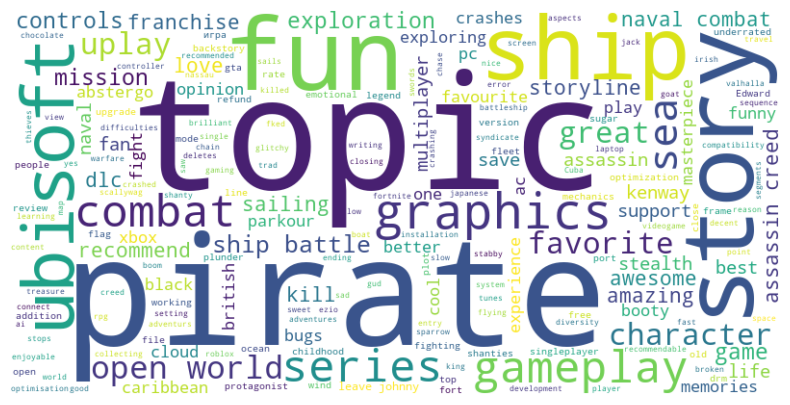

In [210]:
all_words = ' '.join(sample_topics_list)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Next, we will compile these into a dictionary with the counts of each word.

Note that some words may not have been accounted for in the groupings due to spelling mistakes in reviews, or the basic plural forms of words.

In [212]:
sample_word_count = {}
# sample_topic_count = {}

for word in sample_topics_list:
    if word in sample_word_count:
        sample_word_count[word] += 1
    else:
        sample_word_count[word] = 1

print(sample_word_count)

{'enjoyable': 1, 'pirate': 54, 'leave': 3, 'johnny': 3, 'story': 23, 'graphics': 11, 'yes': 1, 'error': 1, 'entry': 1, 'franchise': 5, 'no topic': 90, 'battleship': 1, 'awesome': 5, 'king': 1, 'seas': 1, 'favorite': 7, 'characters': 6, 'gameplay': 9, 'writing': 1, 'wind': 1, 'sails': 1, 'series': 9, 'sea': 3, 'memories': 3, 'xbox': 3, 'fun': 25, 'addition': 2, 'open world': 8, 'controller': 1, 'bugs': 3, 'decent': 1, 'single player': 1, 'mission': 4, 'fast travel': 1, 'ubisoft': 10, 'deletes': 1, 'killed': 1, 'space': 1, 'sweet': 1, 'funny': 3, 'ship': 8, 'adventures': 1, 'crashes': 3, 'recommend': 5, 'stops working': 1, 'fked up': 1, 'gaming laptop': 1, 'exploration': 6, 'map': 1, 'pirate ship': 2, "kenway's fleet": 2, 'sea combat': 2, 'chase sequence': 1, 'setting': 1, 'scallywag': 1, 'content': 1, 'optimisation': 1, 'assassin': 3, 'life': 2, 'game': 3, 'gud': 1, 'treasure': 1, 'japanese': 1, 'compatibility mode': 1, 'glitchy': 1, 'flying ships': 1, 'ships': 3, 'fan': 4, 'boat segmen

In [213]:
sample_count = pd.DataFrame.from_dict(sample_word_count, orient = 'index', columns = ['count']).sort_values(by = 'count', ascending = False).reset_index(names = 'topic')

In [214]:
print(sample_count.shape)

sample_count.head()

(382, 2)


,topic,count
0,no topic,90
1,pirate,54
2,fun,25
3,story,23
4,pirates,20


This leaves us with 382 'unique' topics from our topic list

In [215]:
sample_words = list(sample_count['topic'])
sample_words

['no topic',
 'pirate',
 'fun',
 'story',
 'pirates',
 'graphics',
 'ubisoft',
 'gameplay',
 'series',
 'ship',
 'open world',
 'great',
 'favorite',
 'controls',
 'exploration',
 'ship battles',
 'uplay',
 'characters',
 'awesome',
 'recommend',
 'franchise',
 'storyline',
 'sailing',
 'naval combat',
 'love',
 'amazing',
 'dlc',
 'multiplayer',
 'fan',
 "assassin's creed",
 'mission',
 'best',
 'ships',
 'british',
 'opinion',
 'kill',
 'stealth',
 'johnny',
 'better',
 'parkour',
 'assassin',
 'game',
 'combat',
 'leave',
 'abstergo',
 'exploring',
 'bugs',
 'memories',
 'crashes',
 'cool',
 'xbox',
 'booty',
 'experience',
 'favourite',
 'sea',
 'funny',
 'masterpiece',
 'review',
 'underrated',
 'optimization',
 'missions',
 'childhood',
 'drm',
 'close',
 'refund',
 'play',
 'plot',
 'gta',
 'save file',
 'top',
 'mechanics',
 'sugar',
 'ship combat',
 'Edward Kenway',
 'protagonist',
 'sea combat',
 'игра',
 "kenway's fleet",
 'old',
 'life',
 'caribbean',
 'one',
 'addition',
 

We will manually group these into categories based on their topics.

In [22]:
categories = {'category': 'sub topics',
              'no topic': '', 
              'pirate theme': ['pirate', 'battleship', 'sea', 'sails', 'sailor', 'ship', 'pirate ship', 'naval', 'navy', 'shanties', 'shanty', 'drunk', 'captain'], 
              'storyline' : ['story', 'ending', 'cut scenes', 'storyline' , 'emotional', 'writing'], 
              'errors' : ['bugs', 'crashes', 'glitchy', "can't play", 'not working', 'broken', 'hardware problem'], 
              'combat': ['combat', 'kill', 'swords', 'fight', 'violence'],
              'optimization': ['optimization'], 
              'frame rate': "frame rate" , 
              'assassin theme': ['assassinate'], 
              'exploration': ['adventure', 'exploration'], 
              'character': ['character'],
              'difficulty': ['difficulty', 'difficult', 'easy'], 
              'uplay': ['uplay', 'ubisoft connect', 'connect', 'xbox', 'playstation'],
              'series' : ['ac', 'series', 'trilogy', 'title'], 
              'graphics': ['atmosphere', 'graphics', 'detail'],
              'customer support': 'support', 
              'cloud mechanics': ['cloud', 'save', 'cloud save'], 
              'animals': ['squirrel', 'dog'] ,
              'full screen': ['full screen', 'windowed mode', 'window'], 
              'entertainment value': ['immersive', 'entertaining', 'replay'],
              'stealth' : ['stealth'],
              'movement': ['run', 'parkour', 'fast travel', 'travel'],
              'music': ['soundtrack', 'music', 'song']}

Let's run this dictionary through the model to prompt it to return those specific topics only.

Before doing so, we should clean the data more so as to not run into any errors, as JSON Errors popped up due to the mismatching apostrophes.

In [217]:
clean_main_reviews_1 =[]
clean_main_reviews = []

for text in ass_creed_no_punc['review']:
    if isinstance(text, str):
        cleaned_text = re.sub(r'\[.*?\]', '', text)   # Getting rid of unwanted punctuation
        clean_main_reviews_1.append(cleaned_text)
    else:
        clean_main_reviews_1.append(text) 

for sentence in clean_main_reviews_1:
    if isinstance(sentence, str):
        quotes_remove = sentence.replace('"', "'") # Replacing any " with ' in a review to avoid JSON errors
        clean_main_reviews.append(quotes_remove)
    else:
        clean_main_reviews.append(sentence) 

clean_main_reviews

['the only game where i avoid fast travel',
 'this is the best assassins creed game and probably the best pirate game ever',
 "best game ever iv 'e been playing from day one (love it and i 'm 75 years young arrrrr matey",
 'shanties before panties',
 "best part of the game are the sea shanties lowkey 1700 's jams be poppin",
 'pros -beautiful graphics -huge artistic work -vast world -naval battles are awesomeeeee -main quest is captivating cons -uplay -same old basic combat system -lack of difficulty -little to no changes in gameplay compared to the older acs -uplay -uplay -seriously... uplay advice disable cloud save sync i lost 15 hours of gameplay because of that idiotic setting and you can avoid that by simply disabling cloud sync',
 "the best assassin 's creed game since assassin 's creed 2 this is coming from someone who hates pirates this game comes in three parts being a assassin being a ship captain and being a ubi i mean abstergo employee the assassin part is similar to the p

In [218]:
ass_creed_no_punc.shape

(21812, 16)

In [219]:
len(clean_main_reviews)

21812

Proceeding to use the model to run through the bigger dataset.

In [72]:
batch_size = 15  # Number of reviews to process in each batch

# reviews_response = reviews_response   #Use this line to continue from where it was left off
reviews_response = []    # Use this line to start from the start

skipped_indexes = skipped_indexes
index = len(reviews_response)

# Looping through through all text reviews and run text analysis for first 1000 of the dataframe in batches of 50
leftover_review = clean_main_reviews[(len(reviews_response)+len(skipped_indexes)):]
total_reviews = len(leftover_review)

# Calculate the total number of batches, accounting for potential remaining reviews
total_batches = (total_reviews + batch_size - 1) // batch_size

for batch_number in tqdm(range(total_batches), total=total_batches):
    start_index = batch_number * batch_size
    end_index = min(start_index + batch_size, total_reviews)  # Ensure we don't go beyond the end of the list
    batch_reviews = leftover_review[start_index:end_index]  # Get a batch of reviews

    batch_responses = []  # List to store responses for this batch

    for review in tqdm(batch_reviews, desc=f"Batch {batch_number+1}/{total_batches}"): # Add a description to the tqdm progress bar
        # try translation and sentiment inference based on prompt until an error is encountered
        prompt = f"""
    
        Perform the following action on the given text delimited by triple backticks:

        1) Categorise each review using the {categories} dictionary.
        - The listed dictionary consists of the key main category, and the values of example sub topics associated with the category.
        
        2) Each review is allowed to have multiple categories.

        3) If no category can be identified, return 'no topic'.
        
        Return the output in the following format:
        {{"categories": list of categories,
        "review": {review}}}
        
        Text to perform actions: ```{review}```
        """

        
        retry_count = 0  # Initialize the retry count for this item
        while retry_count < 1:  # Maximum of 5 retries for a specific item
            try:
                response = extract_topic_with_retry(prompt)  # Use the retry-enabled function
                batch_responses.append(response)
                index += 1
                break  # Break out of the loop if successful
            except JSONDecodeError as jde:
                # If JSONDecodeError occurs, it will retry in the next iteration of the loop
                retry_count += 1  # Increment the retry count
                print(f"JSONDecodeError encountered. Retrying...")
                continue
            
        else:
            # If maximum retries are reached, print skip message and continue to the next item
            skipped_indexes.append(index)
            index += 1
            print(f"Skipping item {index}/{len(clean_main_reviews)} due to JSON Error (Retried 3 times).")
            continue

    reviews_response.extend(batch_responses)  # Append batch responses to the overall list
        
print(len(reviews_response))
reviews_response

Batch 1/1355:  80%|███████████████████████▏     | 12/15 [00:41<00:10,  3.35s/it]

Error encountered. Retrying in 5 seconds...



Batch 2/1355:  13%|████                          | 2/15 [00:04<00:30,  2.38s/it]

Error encountered. Retrying in 5 seconds...
Error encountered. Retrying in 5 seconds...


  0%|                                     | 1/1355 [11:14<253:48:33, 674.83s/it]


InvalidRequestError: This model's maximum context length is 4097 tokens. However, your messages resulted in 4999 tokens. Please reduce the length of the messages.

In [73]:
len(reviews_response)

1479

Our code stopped at around the 1500 mark due to the entry being too many words. Due to the time crunch value, we decided to stop at this 1500 mark.

It should be noted that this means the data we have labelled are the top weighted 1500 reviews according to Steam, with these reviews having more comments and positive thumbs up from other Steam users.

In [220]:
len(skipped_indexes)

36

It should also be noted that the code had to skip 36 rows due to repeated JSON errors.

In [221]:
review_categories = pd.DataFrame(reviews_response)

In [272]:
# Output for our next notebook to perform Supervised Modellign
review_categories.to_csv('../data/output/top_1500_reviews_categorised.csv', index = False)

In [271]:
review_categories

,categories,review
0,[movement],the only game where i avoid fast travel
1,"[assassin theme, pirate theme]",this is the best assassins creed game and prob...
2,[no topic],best game ever iv 'e been playing from day one...
3,[pirate theme],shanties before panties
4,"[pirate theme, music]",best part of the game are the sea shanties low...
...,...,...
1474,"[storyline, pirate theme, animals]",just like all assassin creed games you go into...
1475,"[graphics, entertainment value, music, pirate ...",excellent graphics excellent game play i love ...
1476,[no topic],this is a fantastic game but for ubisoft to co...
1477,"[errors, combat]",bugs bugs everywhere ship fights are good tho


In [238]:
# Collating all the topics together in a list
categories_list = []

for row in review_categories['categories']:
    for subject in row:
        categories_list.append(subject)

In [239]:
categories_list

['movement',
 'assassin theme',
 'pirate theme',
 'no topic',
 'pirate theme',
 'pirate theme',
 'music',
 'graphics',
 'combat',
 'difficulty',
 'uplay',
 'cloud mechanics',
 'assassin theme',
 'combat',
 'stealth',
 'exploration',
 'storyline',
 'character',
 'graphics',
 'optimization',
 'uplay',
 'uplay',
 'pirate theme',
 'storyline',
 'optimization',
 'series',
 'pirate theme',
 'music',
 'uplay',
 'optimization',
 'customer support',
 'storyline',
 'exploration',
 'graphics',
 'movement',
 'entertainment value',
 'storyline',
 'combat',
 'optimization',
 'movement',
 'graphics',
 'entertainment value',
 'stealth',
 'customer support',
 'pirate theme',
 'storyline',
 'series',
 'exploration',
 'difficulty',
 'graphics',
 'music',
 'story',
 'price',
 'requirements',
 'length',
 'fun',
 'replayability',
 'worth buying',
 'storyline',
 'music',
 'series',
 'gameplay',
 'graphics',
 'storyline',
 'music',
 'entertainment value',
 'optimization',
 'graphics',
 'exploration',
 'combat

In [240]:
# Combining this into a dictionary so we can quantify this in a table or graph format
word_counting = {}
categories_count = {}

for word in categories_list:
    if word in word_counting:
        word_counting[word] += 1
    else:
        word_counting[word] = 1

print(word_counting)

{'movement': 101, 'assassin theme': 190, 'pirate theme': 454, 'no topic': 262, 'music': 116, 'graphics': 369, 'combat': 304, 'difficulty': 40, 'uplay': 243, 'cloud mechanics': 20, 'stealth': 57, 'exploration': 279, 'storyline': 536, 'character': 153, 'optimization': 142, 'series': 398, 'customer support': 91, 'entertainment value': 233, 'story': 21, 'price': 14, 'requirements': 6, 'length': 5, 'fun': 5, 'replayability': 7, 'worth buying': 5, 'gameplay': 19, 'errors': 146, 'animals': 16, 'specs': 1, 'graphics/art style': 1, 'audio': 8, 'pc requirements': 8, 'difficulity': 4, 'grind': 3, 'game time': 8, 'bugs': 17, 'worth paying for': 1, 'frame rate': 45, 'grinding': 1, 'game time/length': 1, 'enjoyment': 1, 'audience': 7, 'game time / length': 1, 'price / quality': 1, 'full screen': 32, 'game length': 2, 'cinematic /art.': 1, 'music /sound.': 1, 'others': 1, 'servers': 1, 'status': 1, 'matchmaking': 1, 'salt level': 1, 'cutscenes': 1, 'multiplayer': 1, 'singleplayer': 1, 'details': 1, '

In [255]:
unique_words = pd.DataFrame.from_dict(word_counting, orient = 'index', columns = ['count'])

In [256]:
unique_words.sort_values(by = 'count', ascending = False, inplace = True)

In [257]:
unique_words.reset_index(names = 'topic', inplace = True)

In [258]:
unique_words

,topic,count
0,storyline,536
1,pirate theme,454
2,series,398
3,graphics,369
4,combat,304
...,...,...
64,enjoyment,1
65,game time/length,1
66,grinding,1
67,worth paying for,1


In the end, we are left with 69 unique topics. Let's check this out in a bar graph to visualise the number of entries with these topics.

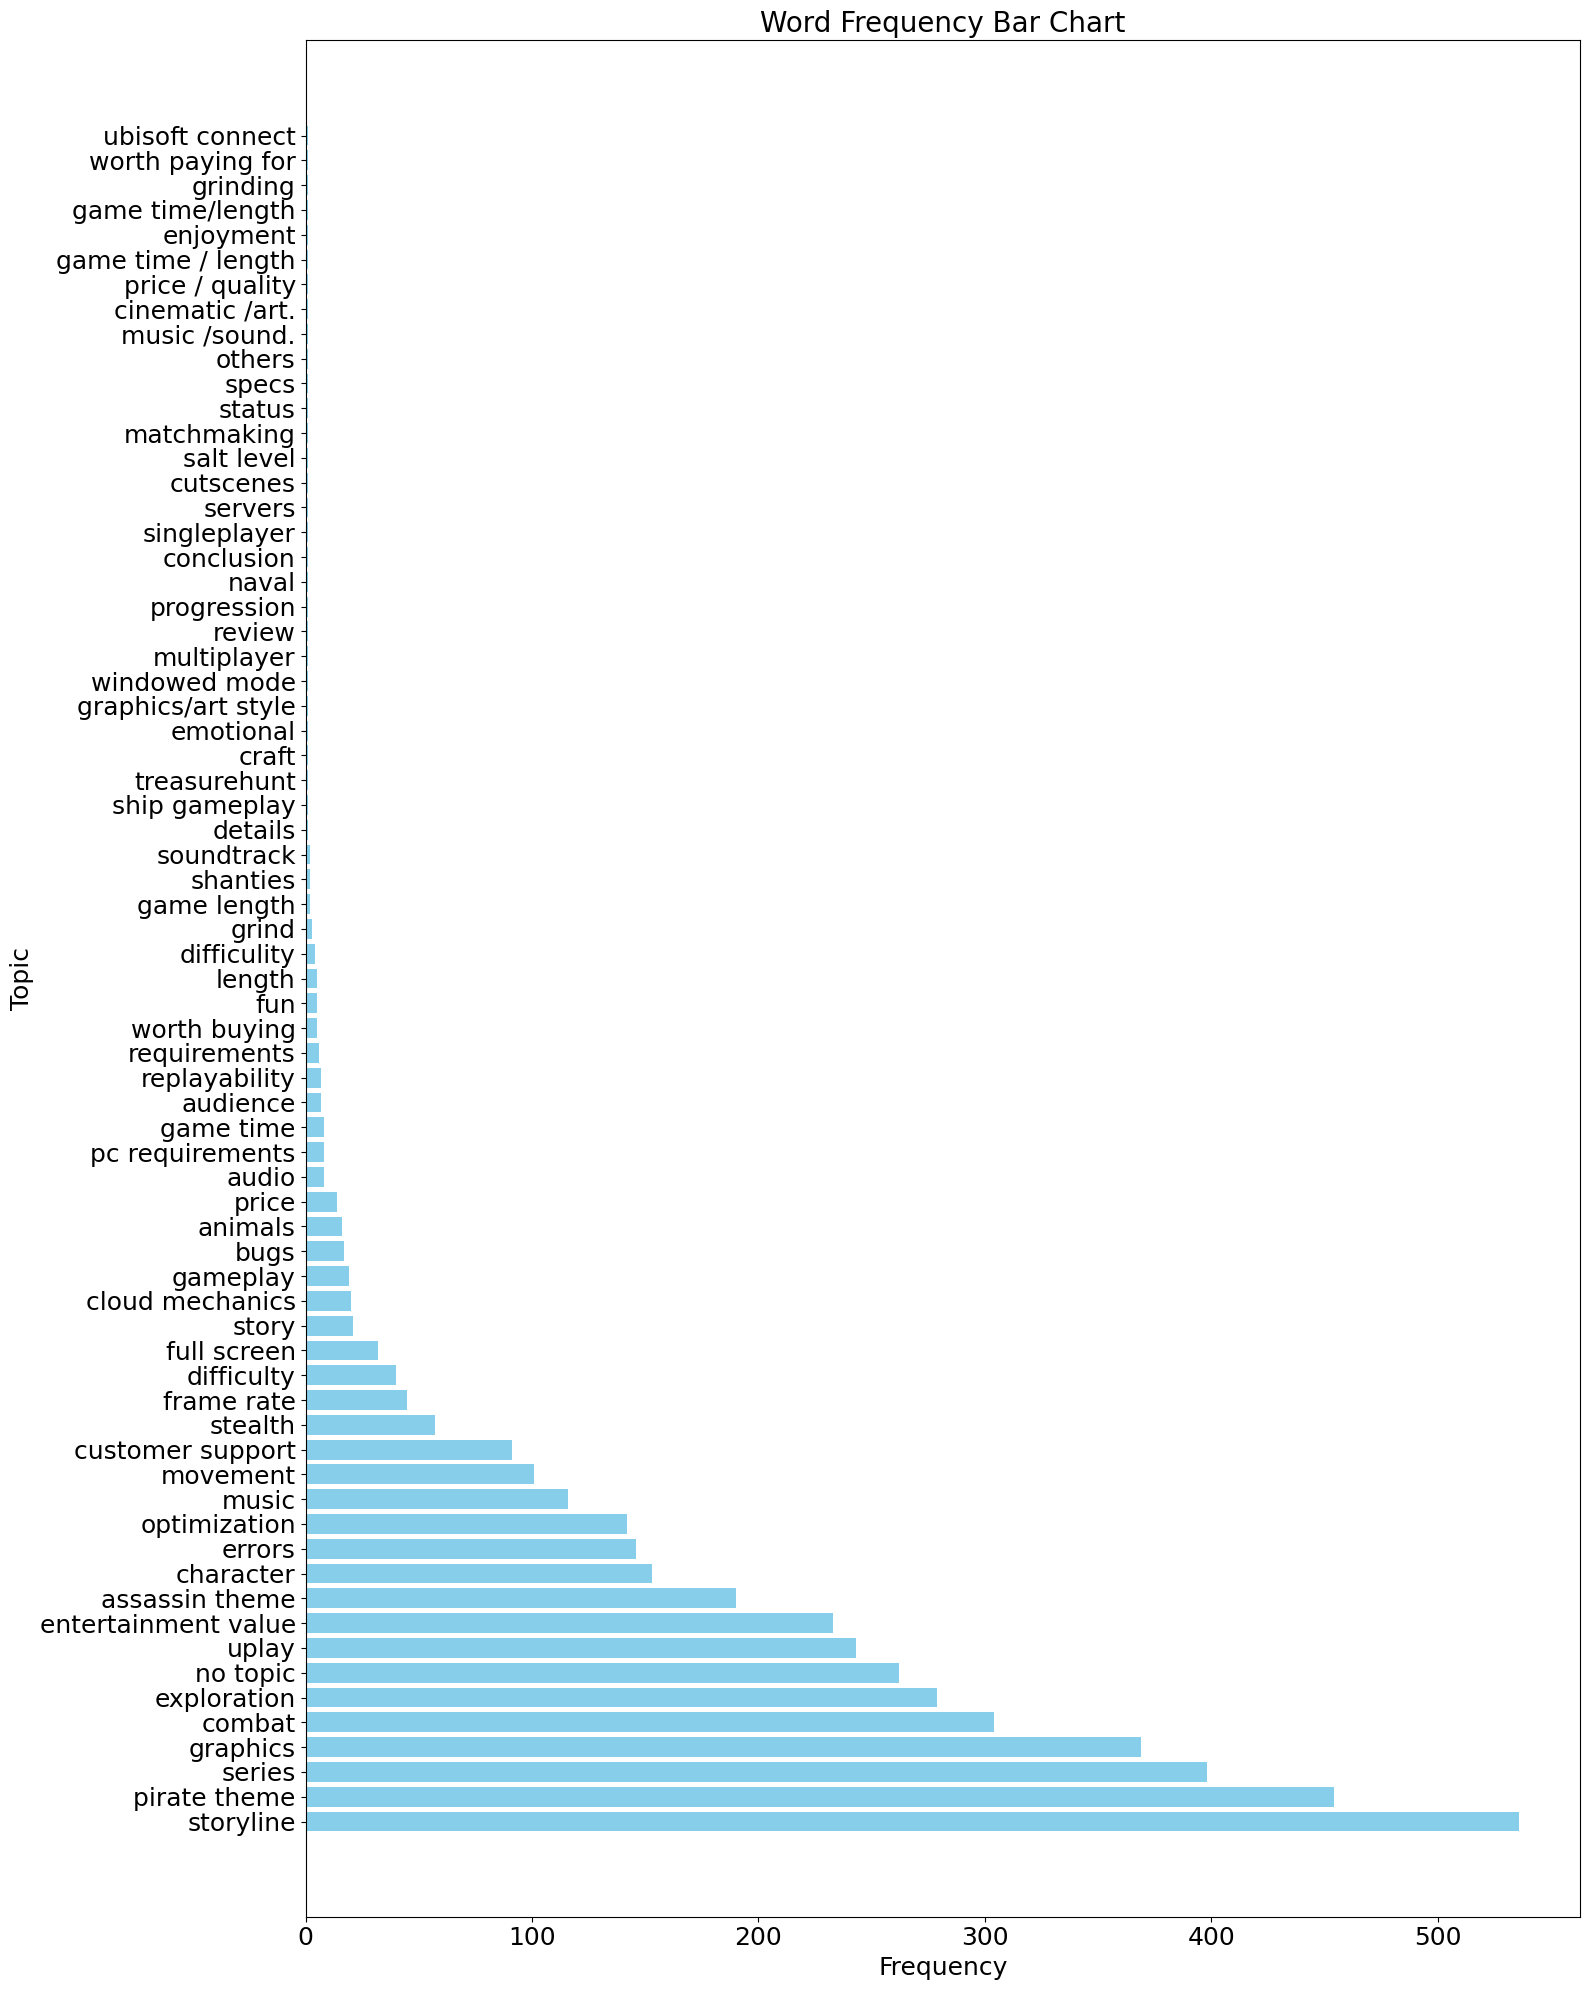

In [267]:
plt.figure(figsize=(16, 20))
plt.barh(unique_words['topic'], unique_words['count'], color='skyblue')
plt.xlabel('Frequency', fontsize = 18)
plt.ylabel('Topic', fontsize = 18)
plt.title('Word Frequency Bar Chart', fontsize=20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

plt.tight_layout()
plt.show()

In the next notebook, we will use this information to combine and/or drop certain topics, to make sure we have as minimal topics for our supervised model to handle as possible.

Moving on, we will be experimenting to find the best supervised model to use to accurately output our labels for each review.